In [1]:
import numpy as np
import seaborn as sns
# Matplotlib for additional customization
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import pandas as pd
from datetime import datetime, timedelta

In [2]:
#assume the order of coords 
#and presume all more than 2d models have homogenous step and bounds
def visualize_list_of_rectangles_as_patches( list_r, ident, i, j ):
    ctverecky = pd.DataFrame({
        "x" : [],
        "y" : []
    })
    wid = 5
    hei = 5
    fig,ax = plt.subplots(1, 1, figsize=(wid, hei))
    sns.scatterplot(x="x", y="y", data=ctverecky, markers="s", s=10)
    
    ax.set(xlim=(x0min, x0max))
    ax.set(ylim=(x1min, x1max))
    for r in list_r:
        px = tresholds[i][r[i]]
        py = tresholds[j][r[j]]
        pw = stepX0
        ph = stepX1
        ax.add_patch( matplotlib.patches.Rectangle((px, py), pw, ph, alpha=0.5, fill=True, color='green', lw=0) )
    plt.savefig('./outParam/img'+str(ident)+'.png', dpi=300)
    plt.clf()
    plt.close()

#expects 2d lists
def visualize_lists_of_rectangles_as_colourful_patches( rlists, colorlist, ident, i, j ):
    #the phase space whiteboard (scatterplot creates circles for all types of markers, we want rectangles)
    ctverecky = pd.DataFrame({
        "x" : [],
        "y" : []
    })
    wid = 5
    hei = 5
    fig,ax = plt.subplots(1, 1, figsize=(wid, hei))
    sns.scatterplot(x="x", y="y", data=ctverecky, markers="s", s=10)
    
    #the rectangles by matplotlib.patches
    alph = 0.1#1.0 / len(colorlist)
    ax.set(xlim=(x0min, x0max))
    ax.set(ylim=(x1min, x1max))
    for k in range( 0, len(colorlist) ):
        list_r = rlists[k]
        for r in list_r:
            px = tresholds[i][r[i]]
            py = tresholds[j][r[j]]
            pw = stepx0
            ph = stepx1
            ax.add_patch( matplotlib.patches.Rectangle((px, py), pw, ph, alpha=alph, fill=True, color=colorlist[k], lw=0) )
    plt.savefig('./outParam/img'+str(ident)+'.png', dpi=300)
    plt.clf()
    plt.close()

def projection( rlist, varx, vary ):
    result = []
    for r in rlist :
        result += [ [ r[varx], r[vary] ] ]
    return result

#e.g. {[0.133984375,0.2],[0.21274414062500002,0.30000000000000004],[0.30625,0.5]}
def str_to_slodi( strslodi ):
    result = []
    strslodi1 = strslodi.replace("(","[") #for the simplicity of the vis only
    iparts = strslodi1.split("[")
    first = True
    for ip in iparts:
        if not first:
            a,b = ip[:-2].split(",")
            result += [ [ float(a), float(b) ]]
        else:
            first = False
    return result
    
#print(str(str_to_slodi("{[0.133984375,0.2),(0.21274414062500002,0.30000000000000004],[0.30625,0.5]}")))

def strdict_to_slodidict( strdict ):
    result = {}
    #input dictionary {rhash : [ entryhash+slodihash="0 -1: {[1.7,1.8)} ]}"
    for rkey in strdict:
        entrylist = strdict[ rkey ]
        newdict = {}
        for estr in entrylist:
            ekey,slodistr = estr.split(":")
            newdict[ekey] = str_to_slodi( slodistr[1:] )
        result[rkey] = newdict
    return result

def nonempty_intersection(i1,i2):
    return (i1[0] <= i2[1]) and (i2[0]<=i1[1])
            
def interval_intersects_slodi( inter, slodi ):
    result = False
    for i in slodi:
        if nonempty_intersection( i, inter ):
            result = True
    return result

def p_in( p, inter):#for the vis we assume all intervals are closed
    return (p >= inter[0]) and (p <= inter[1])

def p_in_slodi( p, slodi ):
    result = False
    for i in slodi:
        if p_in( p, i):
            result = True
    return result

def r_from_h(h): #hash = 1,2,3,...
    r = []
    coordsStrs = h.split(",")
    for cstr in coordsStrs:
        r.append( int(cstr) )
    return r

In [22]:
#assumptions: 1 parameter, running reachability paramFAprototype

def print_basic_stats( n, filename, ident, timestr="%Hh %Mm %Ss" ):
    i = 0 #line counter
    countF = 0
    countQ = 0
    countA = 0
    count_visited_rectangles = 0
    queue_items_popped = 0
    queue_in_time = []
    time_of_comput = ""
    result_slodi = ""
    all_rectangles_list = []
    rectangles_slodi = {} #from adding ...?string key
    rhash = ""
    rectangles_entry_slodi = {} #from visible states output
    admissible_par_valuations = ""

    filepath = "./reachabilita-k-parsovani/" 
    dost = 0
    first_state = True
    firstStateStr = ""

    #read the output file
    with open( filepath + filename ) as infile:
        for line in infile:
            i = i + 1
            if( line == "F\n" ):
                countF += 1
            elif( line == "Q\n" ):
                countQ += 1
            elif( line[:12] == "Adding state"):
                if first_state:
                    i1 = line.find('[')
                    i2 = line.find(']')
                    firstStateStr = line[ i1 : (i2+1) ]
                    i1 = line.find('{')
                    i2 = line.find('}')
                    admissible_par_valuations = line[ i1 : (i2+1) ]
                    first_state = False
                countA += 1
            elif( line[:14] == "   Queue size "):
                queue_in_time.append( int( line[14:-1] ) )
            elif( line[:32] == "Visited states data: checkpoint="):#35334:")
                queue_items_popped = int( line[32:-2] )
            elif( line[:11] == "Rectangle: "): #[64,96], Data: "):
                count_visited_rectangles += 1
                rhash = line[12:-10]
                r = []
                rectangles_entry_slodi[rhash] = []
                coordsStrs = rhash.split(",")
                for cstr in coordsStrs:
                    r.append( int(cstr) )
                all_rectangles_list.append( r )
                #if(dost < 10):
                #    print( str(r) )
                #    dost += 1
            elif( line[:8] == "	dir,or=" ): #0 -1: " #{[1.7,1.8)},"
                entry_elem = line[8:-2]
                rectangles_entry_slodi[ rhash ].append( entry_elem )
            elif( line[:21] == "Result of reach A,B: "):
                result_slodi = line[21:-1]
            elif( line[:20] == "BUILD SUCCESSFUL in "):
                time_of_comput = line[20:-1]

    print("Read " + str(i) + " lines from output file: \n" + filename + "\n" )
    print("Task was reachability from "+firstStateStr+" with parameters in "+admissible_par_valuations)

    #result of reachability task? output interval of valid pars (vis states visited
    #with valid pars)
    #TODO? ze zadanych delt se daji kdyztak pospojovat nazelene intervaly, 
    #kdyz se lisi o mene nez velka delta
    print("Result: B is reachable from A if p is in: \nSLODI " + result_slodi + "\n")
    print("Computation time was "+time_of_comput+"." )


    #count number of visited states and rectangles
    #statistics of states per rectangle (barplot), export graph
    #vis can be lists of rectangles (duplicate by entry), vis with aplha=0.25 
    #and see darker and lighter rectangles
    print("Rectangles visited "+str(count_visited_rectangles)+".")
    count_visited_states = 0
    entrylist_lengths = []
    for rhash in rectangles_entry_slodi:
        entrylist_lengths.append( len( rectangles_entry_slodi[rhash] ) )
        count_visited_states += len( rectangles_entry_slodi[ rhash ] )
    print("States visited "+str(count_visited_states)+".")
    print("Average states per rectangle "+"{:2.1f}".format(count_visited_states/count_visited_rectangles) +".")
    entrylist_sizes = pd.DataFrame({
            "id" : range(0,len(entrylist_lengths)),
            "states per rectangle" : entrylist_lengths
        })
    wid = 5
    hei = 5
    velpis = 15
    fig,ax = plt.subplots(1, 1, figsize=(wid, hei))
    countplot = sns.countplot(x="states per rectangle", data=entrylist_sizes, color="c")
    countplot.tick_params(labelsize=velpis)
    plt.yticks(fontsize=velpis)
    countplot.set_xlabel("states per rectangle", fontsize=velpis)
    countplot.set_ylabel("count",fontsize=velpis)
    plt.tight_layout()
    plt.show()
    #myfig = countplot.get_figure()
    #myfig.savefig("./outParam/out.png",dpi=300) 
    fig.savefig('./outParam/img_STATES_PER_RECTANGLE_'+filename+'.png', dpi=300)
    plt.clf()
    plt.close()

    #compute the dictionary rectangle : parsets slodis under which reached
    #compute the dictionary rectangle: entry: parsets slodis
    #store the dictionary in file
    rh_eh_slodi = strdict_to_slodidict( rectangles_entry_slodi ) #rectangle str entry str parset slodi
    dictfile = './outParam/RECTANGLES_DATA_'+filename
    fo = open( dictfile, "w")
    fo.write( str(rh_eh_slodi) )
    fo.close()

    #process of computation - queue size in time (as in steps) 
    #TODO? (can be also seen when (in terms of steps) a rectangle was added to queue,
    #i.e. reached and not yet explored with given parset, z toho se da visualizovat
    #time posloupnost kudy to slo, tmavnouci nebo svetlajici nebo barvu menici trajectory)
    queue_sizes = pd.DataFrame({
            "states analyzed" : range(0,len(queue_in_time)),
            "states in queue" : queue_in_time
        })
    wid = 5
    hei = 5
    fig,ax = plt.subplots(1, 1, figsize=(wid, hei))
    sns.lineplot(x="states analyzed", y="states in queue", data=queue_sizes )
    plt.savefig('./outParam/img_QUEUE_SIZE_IN_STEPS_'+filename+'.png', dpi=300)
    plt.clf()
    plt.close()

    #known time of computation, num of states analyzed (=checkpoint=num added states)
    #average time per state (rectangle) analysis,
    #the above in relation to QDA FA portions (and globally in relation to all models dim and tres and type of system)
    t = datetime.strptime( time_of_comput, timestr )
    delta = timedelta( hours=t.hour, minutes=t.minute, seconds=t.second)
    print("Computation time " + str(delta.total_seconds()) + " seconds.")

    print("Number of states added to queue (found for first time with given parset) " + str(countA)+".")
    print("Number of states popped from queue " + str(queue_items_popped)+".\n" )

    #compute number of F vs Q computations
    print("FA completed before 1 minute timeout " + str(countF) + " times.")
    print("QDA called after 1 minute timeout " + str(countQ) + " times.\n")

    print("Average time per state analysis " + "{:2.2f}".format( (delta.total_seconds() * 1.0) / queue_items_popped ) + " seconds.\n" )
    #print("Average time per rectangle was ??")
    
    print(ident+"\n\n")
    
    #projection of pairs of vars, vis output export
    for i in range(0,n):
        for j in range(i+1,n):
            visualize_list_of_rectangles_as_patches( all_rectangles_list, filename+"_VARS_"+str(i)+str(j), i, j )

    return [ all_rectangles_list, rh_eh_slodi ]

def visualize_par_intervals( rh_eh_slodi, intervals, colorlist, ident):
    #print(projection(all_rectangles_list, 0, 2))
    #interesting parsets subsets filter state space and visualize
    
    rlists = [ [] ] * len(intervals)
    for rkey in rh_eh_slodi:
        #print(rkey)
        for k in range( 0, len( intervals ) ):
            for ekey in rh_eh_slodi[ rkey ]:
                if interval_intersects_slodi( intervals[k], rh_eh_slodi[rkey][ekey] ):
                    rlists[k] += [ r_from_h(rkey) ]
                    #print("i="+str(i)+" r"+str(r_from_h(rkey)))
    for i in range(0,n):
        for j in range(i+1,n):
            visualize_lists_of_rectangles_as_colourful_patches( rlists, colorlist, ident, i, j )

In [ ]:
#LOTKA VOLTERRA SMALL
n=2
x0min = 0.1
x0max = 0.6
x1min = 0
x1max = 1
pieces_count = 3
stepx0 = ( x0max - x0min ) / pieces_count
stepx1 = ( x1max - x1min ) / pieces_count
tresholdsX0 = [0.1,0.2,0.4,0.6]
tresholdsX1 = [0.0,0.5,0.8,1.0]
tresholds = [ tresholdsX0, tresholdsX1 ]

print_basic_stats( n, filename, ident )

Read 112467 lines from output file: 
2022-03-30-OUTPUT-LV-ReachabilityCaseStudy-50tres-using-fa-timeout-to-qda.txt

Task was reachability from [40,10] with parameters in {[0.1,0.5]}
Result: B is reachable from A if p is in: 
SLODI {[0.133984375,0.2],[0.21274414062500002,0.30000000000000004],[0.30625,0.5]}

Computation time was 3h 49m 44s.
Rectangles visited 1586.
States visited 4139.
Average states per rectangle 2.6.


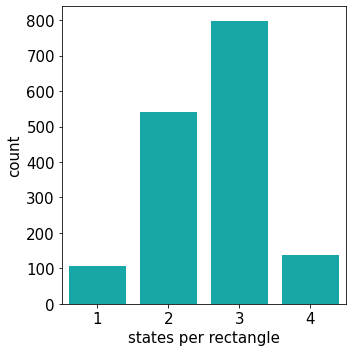

Computation time 13784.0 seconds.
Number of states added to queue (found for first time with given parset) 35334.
Number of states popped from queue 35334.

FA completed before 1 minute timeout 35454 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 0.39 seconds.

LV50x50


In [18]:
#LOTKA VOLTERRA 50x50
filename = "2022-03-30-OUTPUT-LV-ReachabilityCaseStudy-50tres-using-fa-timeout-to-qda.txt"
ident = "LV50x50"

n=2
x0min = 0
x0max = 0.6
x1min = 0
x1max = 1
pieces_count = 50
stepX0 = ( x0max - x0min ) / pieces_count
stepX1 = ( x1max - x1min ) / pieces_count
tresholdsX0 = np.arange ( x0min, x0max+(0.3*stepx0), stepx0 )
tresholdsX1 = np.arange ( x1min, x1max+(0.3*stepx1), stepx1 )
tresholds = [ tresholdsX0, tresholdsX1 ]

#processing:
all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename, ident )

#intervals = [ [0,0.09] ]
intervals = [[0.4,0.5],[0.1,0.19],[0.2,0.29],[0.3,0.39]]
ident = "LV50x50-5-parsets"
colorlist = ['blue','yellow','yellow','blue']
#colorlist = ['yellow']#,'yellow','yellow']
visualize_par_intervals( rh_eh_slodi, intervals, colorlist, ident )

Read 22994 lines from output file: 
2022-03-31-OUTPUT-BRU-ReachabilityCaseStudy-100tres-using-fa-AB.txt

Task was reachability from [10,43] with parameters in {[1.7,3.0]}
Result: B is reachable from A if p is in: 
SLODI {}

Computation time was 2h 24m 44s.
Rectangles visited 3159.
States visited 6173.
Average states per rectangle 2.0.


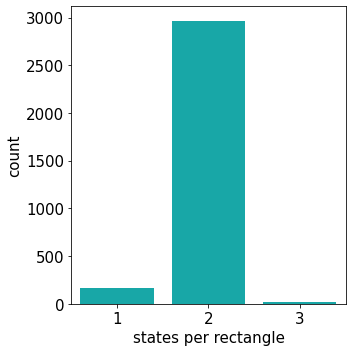

Computation time 8684.0 seconds.
Number of states added to queue (found for first time with given parset) 6825.
Number of states popped from queue 6825.

FA completed before 1 minute timeout 0 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 1.27 seconds.

BRU_AB


Read 22990 lines from output file: 
2022-03-31-OUTPUT-BRU-ReachabilityCaseStudy-100tres-using-fa-AC.txt

Task was reachability from [10,43] with parameters in {[1.7,3.0]}
Result: B is reachable from A if p is in: 
SLODI {}

Computation time was 2h 24m 43s.
Rectangles visited 3159.
States visited 6173.
Average states per rectangle 2.0.


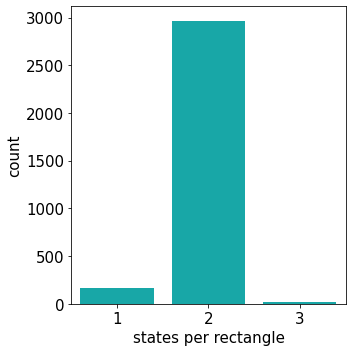

Computation time 8683.0 seconds.
Number of states added to queue (found for first time with given parset) 6825.
Number of states popped from queue 6825.

FA completed before 1 minute timeout 0 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 1.27 seconds.

BRU_AC




In [23]:
#BRUSSELATOR 100x100
filename1 = "2022-03-31-OUTPUT-BRU-ReachabilityCaseStudy-100tres-using-fa-AB.txt"
filename2 = "2022-03-31-OUTPUT-BRU-ReachabilityCaseStudy-100tres-using-fa-AC.txt"

n=2
x0min = 0
x0max = 0.6
x1min = 0
x1max = 0.6
pieces_count = 100
stepx0 = ( x0max - x0min ) / pieces_count
stepx1 = ( x1max - x1min ) / pieces_count
tresholdsX0 = np.arange ( x0min, x0max+(0.3*stepx0), stepx0 )
tresholdsX1 = np.arange ( x1min, x1max+(0.3*stepx1), stepx1 )
tresholds = [ tresholdsX0, tresholdsX1 ]

all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename1, "BRU_AB" )
all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename2, "BRU_AC" )

Read 808 lines from output file: 
2022-03-30-OUTPUT-REPRESSILATOR-3D-PWMA-INPUT03-reachAB.txt

Task was reachability from [2,1,1] with parameters in {[0.0,3.0]}
Result: B is reachable from A if p is in: 
SLODI {[0.0,0.1]}

Computation time was 1m 25s.
Rectangles visited 94.
States visited 206.
Average states per rectangle 2.2.


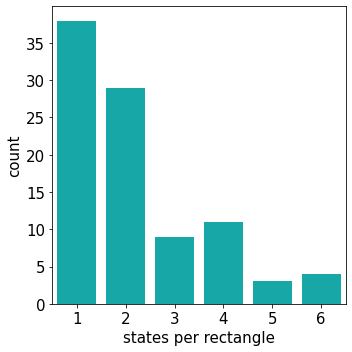

Computation time 85.0 seconds.
Number of states added to queue (found for first time with given parset) 240.
Number of states popped from queue 240.

FA completed before 1 minute timeout 0 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 0.35 seconds.

REP3D_parset0_3


Read 6920 lines from output file: 
2022-03-30-OUTPUT-REPRESSILATOR-3D-PWMA-reachAB.txt

Task was reachability from [2,1,1] with parameters in {[-1.0,3.0]}
Result: B is reachable from A if p is in: 
SLODI {[-1.0,0.14999999999999988]}

Computation time was 31m 40s.
Rectangles visited 419.
States visited 1358.
Average states per rectangle 3.2.


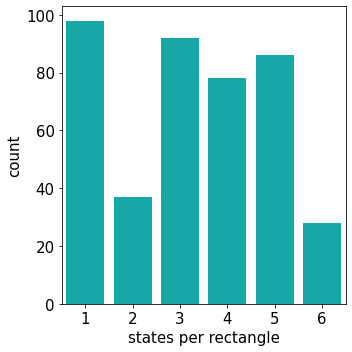

Computation time 1900.0 seconds.
Number of states added to queue (found for first time with given parset) 2413.
Number of states popped from queue 2413.

FA completed before 1 minute timeout 0 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 0.79 seconds.

REP3D_parset-1_3




In [24]:
#REPRESSILATOR 3D
filename1 = "2022-03-30-OUTPUT-REPRESSILATOR-3D-PWMA-INPUT03-reachAB.txt"
filename2 = "2022-03-30-OUTPUT-REPRESSILATOR-3D-PWMA-reachAB.txt"

n = 3
pieces_count = 9
stepX0 = 2.011341
stepX1 = 2.011341
stepX2 = 2.011341
tresholdsX0 = [0.000000, 2.011341, 2.921948, 3.692462, 5.563709, 6.284189, 7.074716, 8.035357, 9.336224, 10.000000 ]
tresholdsX1 = [0.000000, 2.011341, 2.921948, 3.692462, 5.563709, 6.284189, 7.074716, 8.035357, 9.336224, 10.000000 ]
tresholdsX2 = [0.000000, 2.011341, 2.921948, 3.692462, 5.563709, 6.284189, 7.074716, 8.035357, 9.336224, 10.000000 ]
tresholds = [ tresholdsX0, tresholdsX1, tresholdsX2 ]


all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename1, "REP3D_parset0_3", timestr="%Mm %Ss" )
all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename2, "REP3D_parset-1_3", timestr="%Mm %Ss" )

Read 14357 lines from output file: 
2022-03-29-OUTPUT-SEIRnorm10-combined-timeout1min-reachAB.txt

Task was reachability from [9,0,0,0] with parameters in {[0.1,1.0]}
Result: B is reachable from A if p is in: 
SLODI {[0.7000000000000001,1.0]}

Computation time was 5h 42m 32s.
Rectangles visited 1154.
States visited 2965.
Average states per rectangle 2.6.


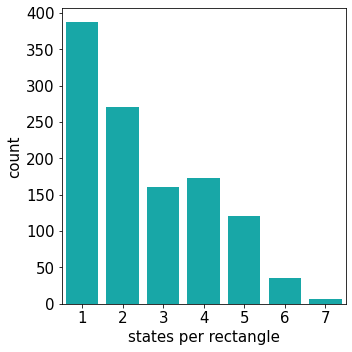

Computation time 20552.0 seconds.
Number of states added to queue (found for first time with given parset) 3360.
Number of states popped from queue 3360.

FA completed before 1 minute timeout 1401 times.
QDA called after 1 minute timeout 2053 times.

Average time per state analysis 6.12 seconds.

SEIR_init9000




In [26]:
#SEIR 4D
filename = "2022-03-29-OUTPUT-SEIRnorm10-combined-timeout1min-reachAB.txt"

n = 4
pieces_count = 10
stepX0 = 0.1
stepX1 = 0.1
tresholdsX0 = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
tresholdsX1 = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
tresholdsX2 = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
tresholdsX3 = [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
tresholds = [ tresholdsX0, tresholdsX1, tresholdsX2, tresholdsX3 ]

all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename, "SEIR_init9000") #, timestr="%Mm %Ss" )


Read 5844 lines from output file: 
2022-03-30-OUTPUT-Repressilator5DVerySimple-4tres-PWMA-00000.txt

Task was reachability from [0,0,0,0,0] with parameters in {[0.0,3.0]}
Result: B is reachable from A if p is in: 
SLODI {[0.0,3.0]}

Computation time was 3h 51m 40s.
Rectangles visited 243.
States visited 1034.
Average states per rectangle 4.3.


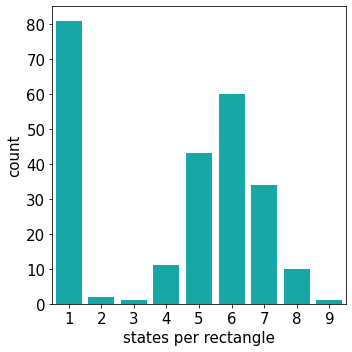

Computation time 13900.0 seconds.
Number of states added to queue (found for first time with given parset) 2052.
Number of states popped from queue 2052.

FA completed before 1 minute timeout 0 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 6.77 seconds.

REP5D_init00000


Read 2348 lines from output file: 
2022-03-31-OUTPUT-Repressilator5D-VerySimple-reach2xxxx-init00000-param-50.txt

Task was reachability from [0,0,0,0,0] with parameters in {[-5.0,0.0]}
Result: B is reachable from A if p is in: 
SLODI {[-5.0,0.0]}

Computation time was 7h 16m 4s.
Rectangles visited 243.
States visited 595.
Average states per rectangle 2.4.


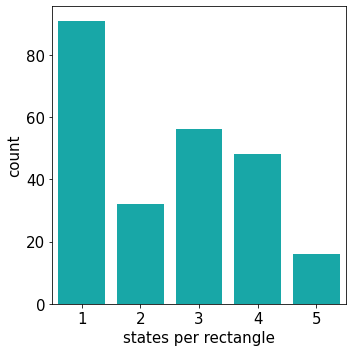

Computation time 26164.0 seconds.
Number of states added to queue (found for first time with given parset) 592.
Number of states popped from queue 592.

FA completed before 1 minute timeout 0 times.
QDA called after 1 minute timeout 0 times.

Average time per state analysis 44.20 seconds.

REP5D_init00000_B2xxxx




In [29]:
#REPRESSILATOR 5D
filename1 = "2022-03-30-OUTPUT-Repressilator5DVerySimple-4tres-PWMA-00000.txt"
#filename = "2022-03-30-OUTPUT-REPRESSILATOR-5D-PWMA-reachAB-NEKOMPLETNI.txt"
filename2 = "2022-03-31-OUTPUT-Repressilator5D-VerySimple-reach2xxxx-init00000-param-50.txt"

n = 5
pieces_count = 3
stepX0 = 3.692462
stepX1 = 3.692462
tresholdsX0 = [0.000000, 3.692462, 7.074716, 10.000000]
tresholdsX1 = [0.000000, 3.692462, 7.074716, 10.000000]
tresholdsX2 = [0.000000, 3.692462, 7.074716, 10.000000]
tresholdsX3 = [0.000000, 3.692462, 7.074716, 10.000000]
tresholdsX4 = [0.000000, 3.692462, 7.074716, 10.000000]
tresholds = [ tresholdsX0, tresholdsX1, tresholdsX2, tresholdsX3, tresholdsX4 ]

all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename1, "REP5D_init00000") #, timestr="%Mm %Ss" )
all_rectangles_list,rh_eh_slodi = print_basic_stats( n, filename2, "REP5D_init00000_B2xxxx") #, timestr="%Mm %Ss" )
